# Projet de Machine Learning 2024 - 2025
Stephen Cohen - Kien PHAM TRUNG - Antoine Rech--Tronville

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shap

c:\Users\Stephen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analyse des données

### Présentation

Notre jeu de données combine plusieurs sources :

1. Données immobilières (mutations_d75.csv) :
   - Transactions immobilières sur Paris et l'île de France
   - Variables principales : date_mutation, type_bien, surface, prix, code_insee
   
2. Données macroéconomiques :
   - Indice de confiance des ménages (confiance_menage.csv)
   - Taux directeur de la BCE (taux.csv)
   - Cours du pétrole Brent (petrole.csv)

Cette combinaison nous permet d'analyser l'impact des facteurs économiques sur les prix immobiliers.

Notre objectif est d'essayer de prédire au mieux le prix d'un appartement selon le contexte économique et les caractéristiques de l'appartement.

In [2]:
df = pd.read_pickle('processed_data/clean_data.pkl')

print("Aperçu des données :")
display(df.head())
print("\nStatistiques descriptives :")
display(df.describe())

Aperçu des données :


,year_month,l_codinsee,type_bien,surface,prix_m2,departement,valeurfonc,date,confiance_menages,taux_directeur,cours_petrole
4,2015-04,75120,UN APPARTEMENT,61.0,4836.065574,75,295000.0,NaT,NaN,NaN,NaN
5,2015-12,75111,UN APPARTEMENT,50.0,5840.000000,75,292000.0,NaT,NaN,NaN,NaN
6,2024-01,75118,UN APPARTEMENT,22.0,11272.727273,75,248000.0,2024-01-01,94.446667,3.894,82.49
7,2024-01,75118,UN APPARTEMENT,22.0,11272.727273,75,248000.0,2024-01-02,94.573333,3.906,82.49
8,2024-01,75118,UN APPARTEMENT,22.0,11272.727273,75,248000.0,2024-01-03,94.700000,3.904,82.49



Statistiques descriptives :


,surface,prix_m2,valeurfonc,date,confiance_menages,taux_directeur,cours_petrole
count,1.966462e+07,1.966462e+07,1.966462e+07,18854925,1.885492e+07,1.864205e+07,1.885492e+07
mean,6.187738e+02,4.547486e+03,4.318239e+05,2021-11-23 12:07:56.155021312,9.361563e+01,5.103527e-01,7.806843e+01
min,1.000000e+00,8.400000e-01,1.000000e+00,2014-01-01 00:00:00,8.300000e+01,-5.930000e-01,4.196000e+01
25%,4.500000e+01,1.250000e+03,1.800000e+05,2020-11-03 00:00:00,8.692116e+01,-5.670000e-01,6.664667e+01
50%,7.200000e+01,3.642857e+03,2.800000e+05,2021-11-15 00:00:00,9.394000e+01,-5.510000e-01,8.249000e+01
75%,2.580000e+02,6.891304e+03,4.400000e+05,2022-12-12 00:00:00,9.830417e+01,1.404000e+00,8.889473e+01
max,6.098051e+06,1.769964e+04,3.411290e+08,2024-06-28 00:00:00,1.107867e+02,3.913000e+00,1.009300e+02
std,1.401090e+04,3.817738e+03,1.435034e+06,NaN,6.811996e+00,1.699023e+00,1.554184e+01


Le Volume de données est très important avec plus de 19,6 millions de transactions.
Voici les caractéristiques : 
- Prix moyen au m² : 4,547€ avec un écart-type de 3,818€, indiquant une forte dispersion
- Les surfaces varient considérablement (moyenne 619m², écart-type 14,011m²)
- Distribution des prix asymétrique : beaucoup de biens à prix modéré et quelques biens très chers tirant la moyenne vers le haut
- Période couverte : 2014-2024, donnant une bonne perspective historique

Les fortes de variations de prix et de distribution sont probablement dû aux différences entre départements et aux types de bien étudiés (pré ou appartement)

**Prétraitement :**

1. Aperçu global des valeurs manquantes:
--------------------------------------------------
Nombre total de valeurs manquantes: 3451638
Pourcentage total de valeurs manquantes: 1.60%

2. Analyse par colonne:
--------------------------------------------------
                   Valeurs manquantes  Pourcentage manquant
taux_directeur                1022568              5.200041
date                           809690              4.117497
confiance_menages              809690              4.117497
cours_petrole                  809690              4.117497
year_month                          0              0.000000
l_codinsee                          0              0.000000
type_bien                           0              0.000000
surface                             0              0.000000
prix_m2                             0              0.000000
departement                         0              0.000000
valeurfonc                          0              0.000000


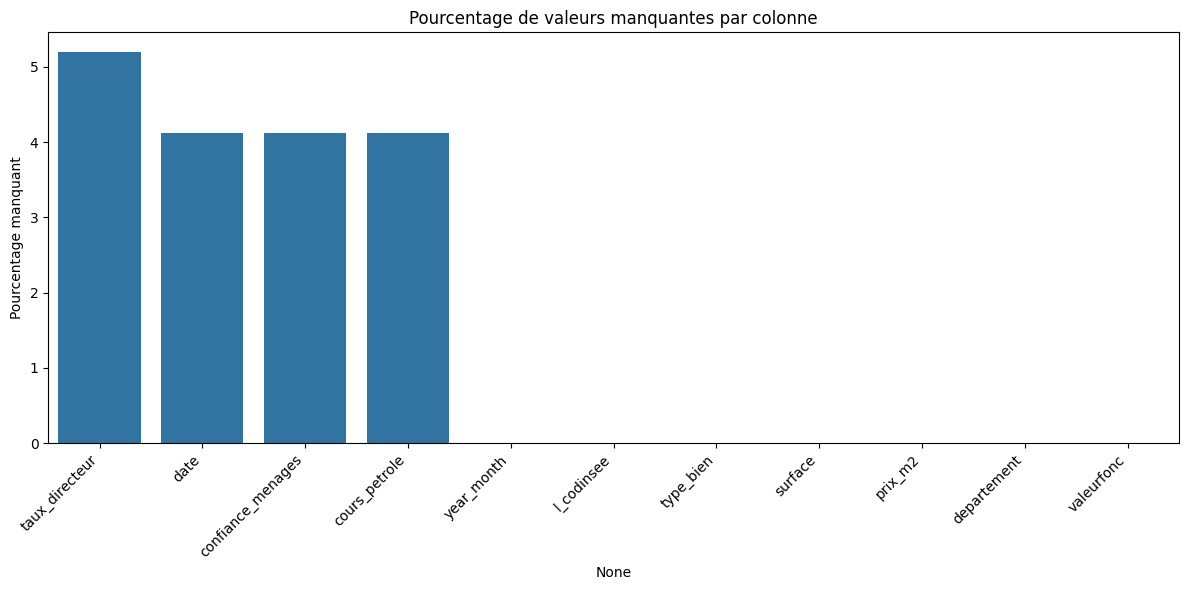


3. Détail des colonnes avec valeurs manquantes:
--------------------------------------------------

Colonne: taux_directeur
Nombre de valeurs manquantes: 1022568
Pourcentage manquant: 5.20%
Statistiques de la colonne:
count    1.864205e+07
mean     5.103527e-01
std      1.699023e+00
min     -5.930000e-01
25%     -5.670000e-01
50%     -5.510000e-01
75%      1.404000e+00
max      3.913000e+00
Name: taux_directeur, dtype: float64

Colonne: date
Nombre de valeurs manquantes: 809690
Pourcentage manquant: 4.12%

Colonne: confiance_menages
Nombre de valeurs manquantes: 809690
Pourcentage manquant: 4.12%
Statistiques de la colonne:
count    1.885492e+07
mean     9.361563e+01
std      6.811996e+00
min      8.300000e+01
25%      8.692116e+01
50%      9.394000e+01
75%      9.830417e+01
max      1.107867e+02
Name: confiance_menages, dtype: float64

Colonne: cours_petrole
Nombre de valeurs manquantes: 809690
Pourcentage manquant: 4.12%
Statistiques de la colonne:
count    1.885492e+07
mean     7.8

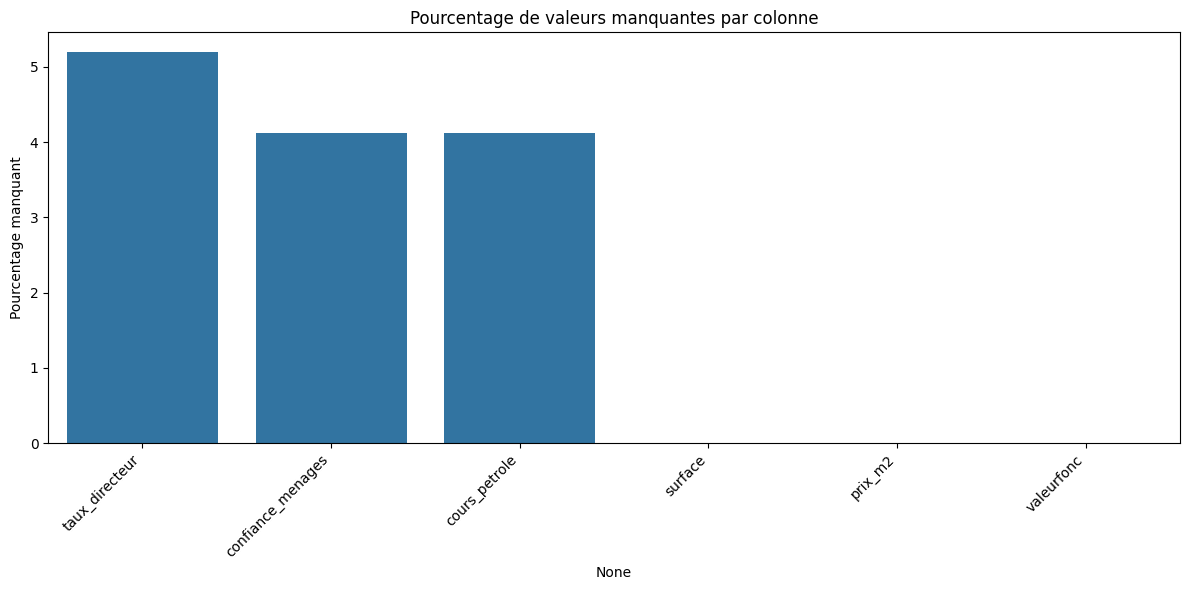


3. Détail des colonnes avec valeurs manquantes:
--------------------------------------------------

Colonne: taux_directeur
Nombre de valeurs manquantes: 1022568
Pourcentage manquant: 5.20%
Statistiques de la colonne:
count    1.864205e+07
mean     5.103527e-01
std      1.699023e+00
min     -5.930000e-01
25%     -5.670000e-01
50%     -5.510000e-01
75%      1.404000e+00
max      3.913000e+00
Name: taux_directeur, dtype: float64

Colonne: confiance_menages
Nombre de valeurs manquantes: 809690
Pourcentage manquant: 4.12%
Statistiques de la colonne:
count    1.885492e+07
mean     9.361563e+01
std      6.811996e+00
min      8.300000e+01
25%      8.692116e+01
50%      9.394000e+01
75%      9.830417e+01
max      1.107867e+02
Name: confiance_menages, dtype: float64

Colonne: cours_petrole
Nombre de valeurs manquantes: 809690
Pourcentage manquant: 4.12%
Statistiques de la colonne:
count    1.885492e+07
mean     7.806843e+01
std      1.554184e+01
min      4.196000e+01
25%      6.664667e+01
50% 

In [3]:
def analyze_missing_values(df):
    """
    Analyse complète des valeurs manquantes dans le dataframe
    """
    print("1. Aperçu global des valeurs manquantes:")
    print("-" * 50)
    
    # Nombre total de valeurs manquantes
    total_missing = df.isnull().sum().sum()
    total_cells = df.size
    percent_missing = (total_missing / total_cells) * 100
    
    print(f"Nombre total de valeurs manquantes: {total_missing}")
    print(f"Pourcentage total de valeurs manquantes: {percent_missing:.2f}%\n")
    
    missing_stats = pd.DataFrame({
        'Valeurs manquantes': df.isnull().sum(),
        'Pourcentage manquant': (df.isnull().sum() / len(df)) * 100
    })
    missing_stats = missing_stats.sort_values('Valeurs manquantes', ascending=False)
    
    print("2. Analyse par colonne:")
    print("-" * 50)
    print(missing_stats)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_stats.index, y='Pourcentage manquant', data=missing_stats)
    plt.xticks(rotation=45, ha='right')
    plt.title('Pourcentage de valeurs manquantes par colonne')
    plt.tight_layout()
    plt.show()
    
    
    columns_with_missing = missing_stats[missing_stats['Valeurs manquantes'] > 0]
    if not columns_with_missing.empty:
        print("\n3. Détail des colonnes avec valeurs manquantes:")
        print("-" * 50)
        for col in columns_with_missing.index:
            print(f"\nColonne: {col}")
            print(f"Nombre de valeurs manquantes: {df[col].isnull().sum()}")
            print(f"Pourcentage manquant: {(df[col].isnull().sum() / len(df)) * 100:.2f}%")
            
            if df[col].dtype in ['int64', 'float64']:
                print("Statistiques de la colonne:")
                print(df[col].describe())
    
    print("\n4. Patterns de valeurs manquantes:")
    print("-" * 50)
    pattern_df = df.isnull().value_counts().head()
    print("Top 5 des patterns de valeurs manquantes les plus fréquents:")
    print(pattern_df)

analyze_missing_values(df)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("\n5. Analyse des valeurs manquantes pour les colonnes numériques uniquement:")
print("-" * 50)
analyze_missing_values(df[numeric_cols])



**Corrélation des variables avec le prix au mètre carré :**

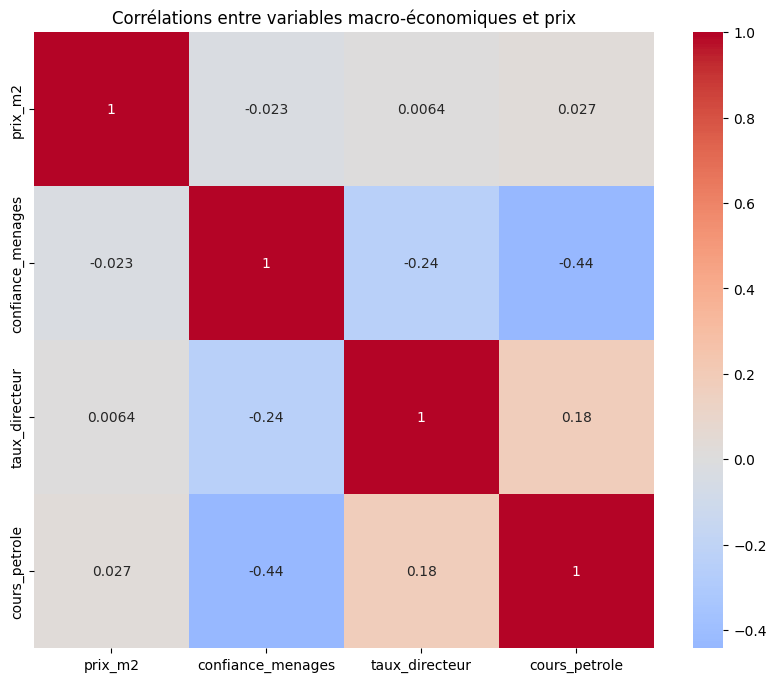

In [4]:
correlations = df[['prix_m2', 'confiance_menages', 'taux_directeur', 'cours_petrole']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations entre variables macro-économiques et prix')
plt.show()


Les trois variables macroéconomiques que nous avons décidé de rajouter à notre jeu de données semblent très peu corrélées avec le prix au mètre carré. Nous allons vérifier cela avec l'importance que les modèles prédictifs leur donnent. 

Cependant, cela nous semble important car pour prédire l'avenir, il faut tenir compte des tendances macroéconomiques.

### Analyse graphique

Analysons la distribution des prix au m² et leur évolution temporelle.

#### Distribution des prix au m2

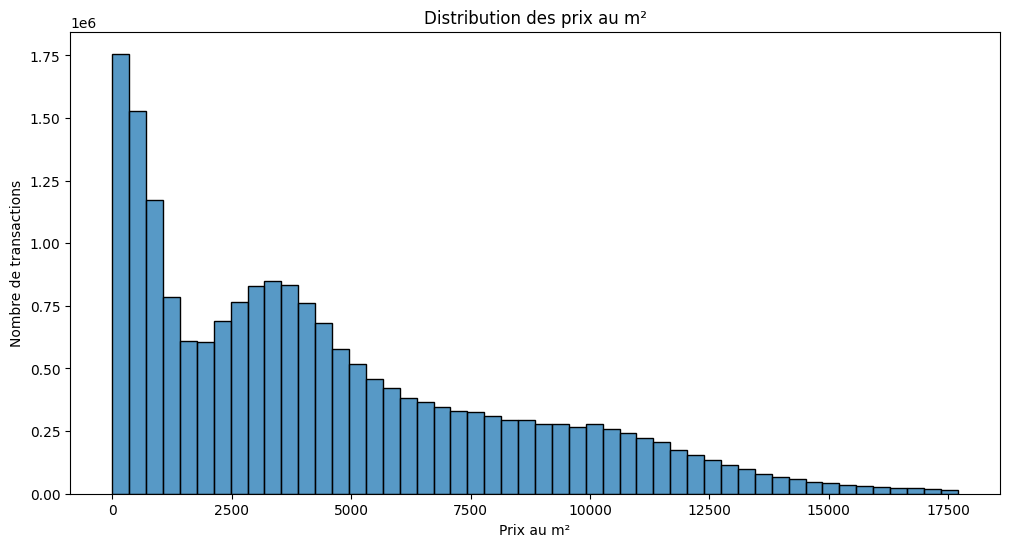

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='prix_m2', bins=50)
plt.title('Distribution des prix au m²')
plt.xlabel('Prix au m²')
plt.ylabel('Nombre de transactions')
plt.show()

#### Prix moyen par département

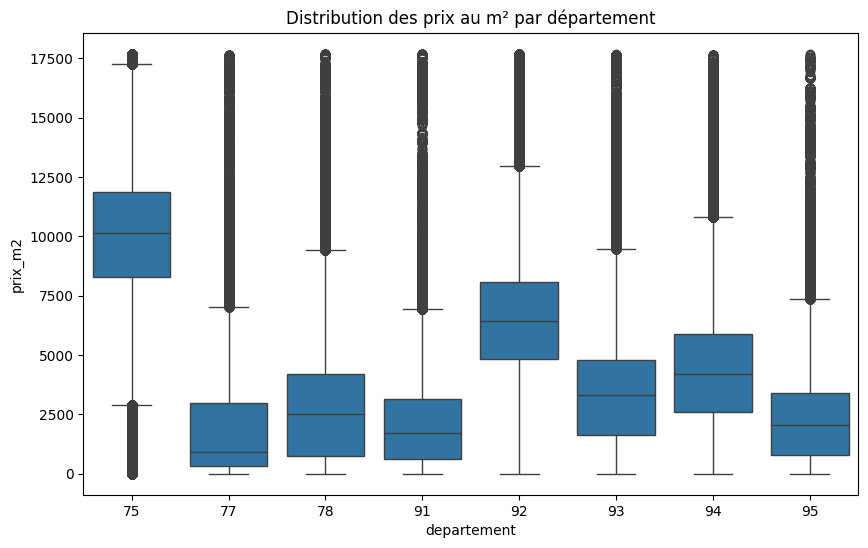

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='departement', y='prix_m2')
plt.title('Distribution des prix au m² par département')
plt.show()

1. Paris (75) se démarque nettement :

- Médiane autour de 10,000€/m²
- Forte dispersion
- Nombreux outliers vers le haut


1. Autres départements d'Île-de-France :

- Prix médians entre 2,500€ et 5,000€/m²
- Dispersion plus modérée
- Gradient de prix clair selon la distance à Paris


**Cela laisse paraître que le département est une variable clé**

#### Evolution temporelle

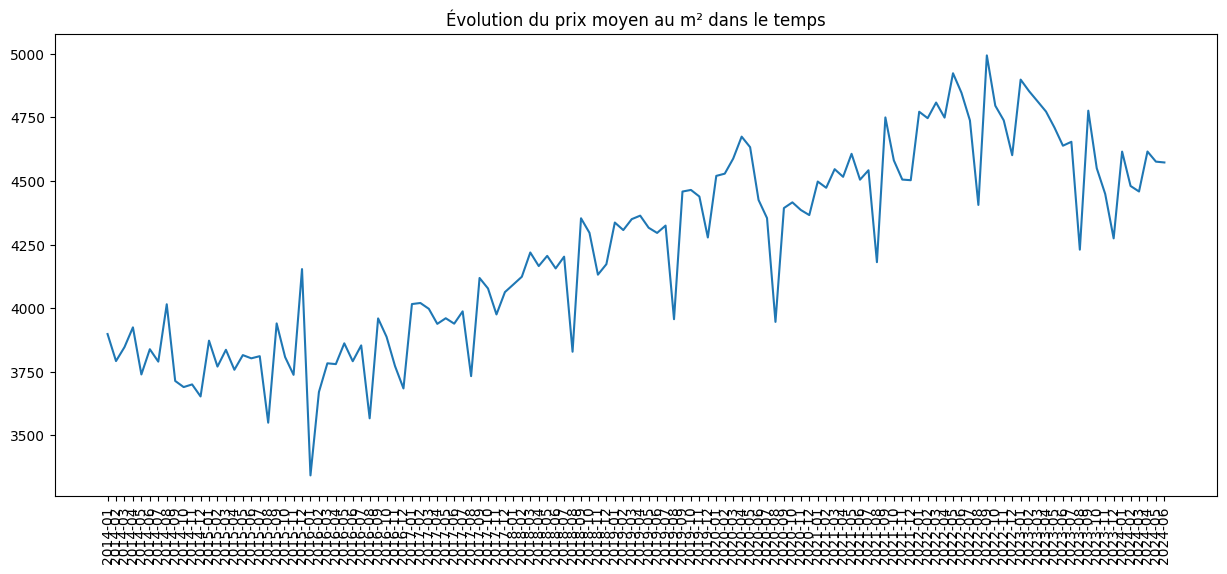

In [7]:
prix_temps = df.groupby('year_month')['prix_m2'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.plot(prix_temps['year_month'].astype(str), prix_temps['prix_m2'])
plt.title('Évolution du prix moyen au m² dans le temps')
plt.xticks(rotation=90)
plt.show()

Nous observons une **tendance haussière constante** de 2014 à 2024 avec une progression de 3,500€/m² à 4,500€/m² (+29%)

De plus il y a une volatilité importante avec :

- *Pics ponctuels marqués*
- *Creux notables mais absorption rapide*
- *Accélération visible post-2020* (possible effet Covid)

On semble distinguer une saisonnalité visible mais modérée.

#### Segmentation des données

In [8]:
def segment_data(df):
    # Sélection des variables pour la segmentation
    segmentation_features = ['surface', 'prix_m2']
    
    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[segmentation_features])
    
    # Détermination du nombre optimal de clusters avec elbow method
    inertias = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    # Application du k-means avec le nombre optimal de clusters
    optimal_k = 4  # À ajuster selon l'elbow curve
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['segment'] = kmeans.fit_predict(X_scaled)
    
    return df

# Modèle par segment
def train_segment_models(df, model_class):
    models = {}
    scores = {}
    
    for segment in df['segment'].unique():
        segment_data = df[df['segment'] == segment]
        X = segment_data.drop(['prix_m2', 'segment'], axis=1)
        y = segment_data['prix_m2']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        model = model_class()
        model.fit(X_train, y_train)
        
        scores[segment] = model.score(X_test, y_test)
        models[segment] = model
    
    return models, scores

## Choix et Analyse des modèles 

Nous avons sélectionné trois modèles différents pour la prédiction des prix :

1. **Régression linéaire :**
   - *Avantages :* Simplicité, interprétabilité, rapidité
   - *Inconvénients :* Hypothèses fortes de linéarité, sensible aux outliers
   
2. **Random Forest :**
   - *Avantages :* Gestion des non-linéarités, robustesse aux outliers, peu de paramètres à régler
   - *Inconvénients :* Moins interprétable, plus lent que la régression linéaire
   
3. **XGBoost :**
   - *Avantages :* Performances généralement supérieures, gestion fine des non-linéarités
   - *Inconvénients :* Plus complexe à paramétrer, risque de surapprentissage

### Préparation des données


In [9]:
numeric_features = ['surface', 'confiance_menages', 'taux_directeur', 'cours_petrole']
categorical_features = ['type_bien', 'departement', 'l_codinsee']

### Encodage des variables catégorielles

In [10]:
encoders = {}
X = df[numeric_features].copy()

# POur les valeurs manquantes 

numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

for feature in categorical_features:
    le = LabelEncoder()
    # Gestion des NaN dans les variables catégorielles
    X[feature] = df[feature].fillna('MISSING')  # Remplace les NaN par 'MISSING'
    X[feature] = le.fit_transform(X[feature].astype(str))
    encoders[feature] = le

y = df['prix_m2'].copy()

In [11]:
print("Nombre de valeurs manquantes par colonne :")
print(X.isna().sum())

Nombre de valeurs manquantes par colonne :
surface              0
confiance_menages    0
taux_directeur       0
cours_petrole        0
type_bien            0
departement          0
l_codinsee           0
dtype: int64


### Division train set et data set

In [12]:
# Suppression des lignes où la variable prix_m2 est manquante
mask = ~y.isna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions des ensembles d'entraînement et de test :")
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")

Dimensions des ensembles d'entraînement et de test :
X_train : (15731692, 7)
X_test : (3932923, 7)


## Entrainement et évaluation des modèles

### Initialisation et entraînement


In [13]:
models = {
    'Régression linéaire': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=50,  # Réduit de 100 à 50
        max_depth=5,      # Réduit de 10 à 5
        min_samples_leaf=4,  # Ajout pour accélérer
        n_jobs=-1,          # Utilisation de tous les cœurs
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        max_depth=4,        # Réduit de 6 à 4
        n_estimators=50,    # Réduit de 100 à 50
        learning_rate=0.1,
        tree_method='hist', # Méthode plus rapide
        n_jobs=-1,         # Utilisation de tous les cœurs
        random_state=42
    )
}

# Entraînement et évaluation
results = {}
for name, model in models.items():
    print(f"Entraînement du modèle {name}...")
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }


Entraînement du modèle Régression linéaire...
Entraînement du modèle Random Forest...
Entraînement du modèle XGBoost...


In [14]:
results_df = pd.DataFrame(results).T
display(results_df)

,RMSE,R2,CV_R2_mean,CV_R2_std
Régression linéaire,3485.448410,0.166743,-2.665765,2.572227
Random Forest,2043.330721,0.713622,-0.121692,0.961569
XGBoost,1930.865039,0.744279,-0.083344,1.058347


**Analyse des différents modèles :** 
- XGBoost montre la meilleure performance :

    - R² = 0.744 (74.4% de variance expliquée)
    - RMSE = 1,930€/m²
    - Meilleure stabilité en cross-validation


- Random Forest proche :

    - R² = 0.714
    - RMSE = 2,043€/m²
    - Bonne robustesse


- Régression linéaire décevante :

    - R² = 0.167
    - RMSE = 3,485€/m²
    - Cross-validation très instable

### Importance des variables explicatives

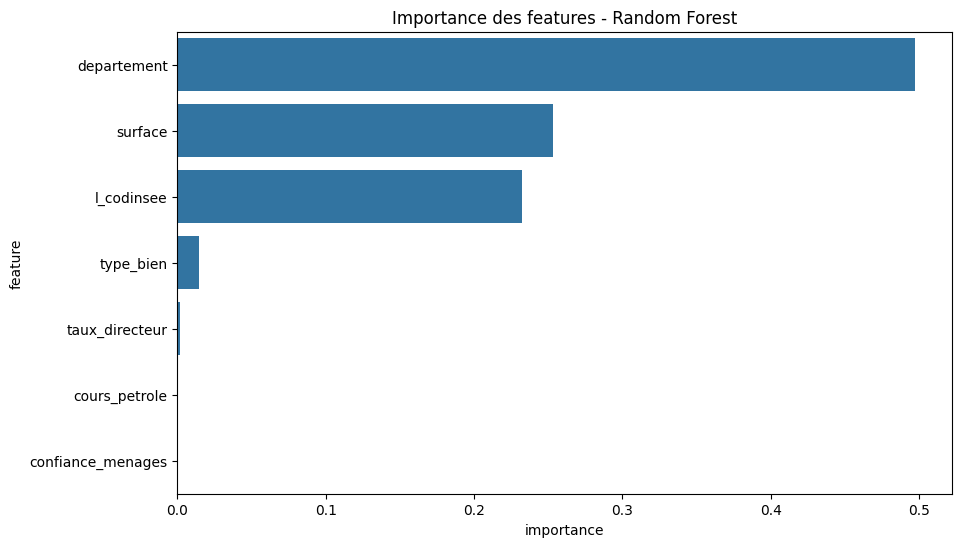

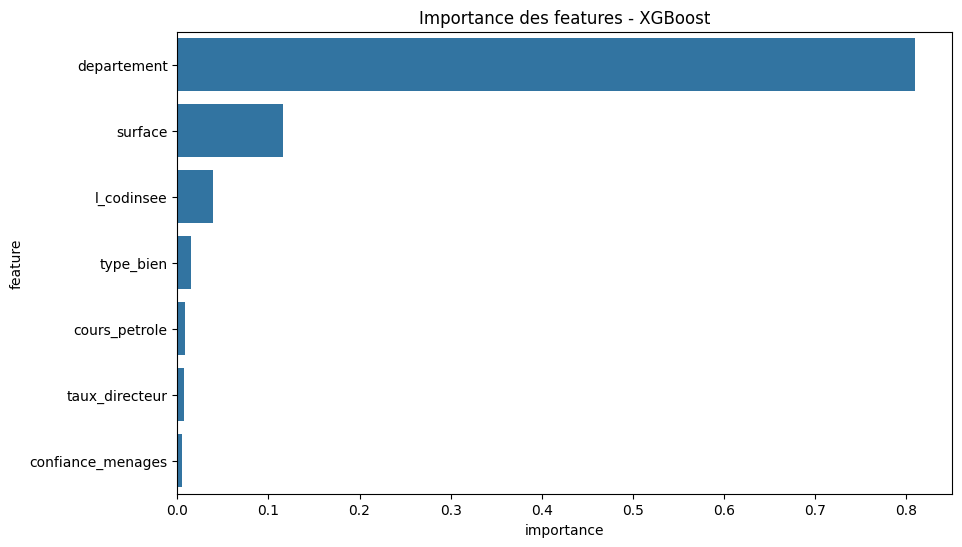

In [15]:
rf_importance = pd.DataFrame({
    'feature': numeric_features + categorical_features,
    'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importance, x='importance', y='feature')
plt.title('Importance des features - Random Forest')
plt.show()

xg_importance = pd.DataFrame({
    'feature': numeric_features + categorical_features,
    'importance': models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=xg_importance, x='importance', y='feature')
plt.title('Importance des features - XGBoost')
plt.show()

**Analyse des variables explicatives :**

- Dominance écrasante de la localisation :

    - XGBoost : département ~80% d'importance
    - Random Forest : département ~50%


- Surface en second facteur :

    - XGBoost : ~10%
    - Random Forest : ~25%


- Variables macroéconomiques marginales :

    - Toutes < 5% d'importance
    - Confirme l'analyse des corrélations


- Code INSEE significatif pour Random Forest (~20%) mais pas pour XGBoost

## Visualisation des résultats

### Comparaison des résultats

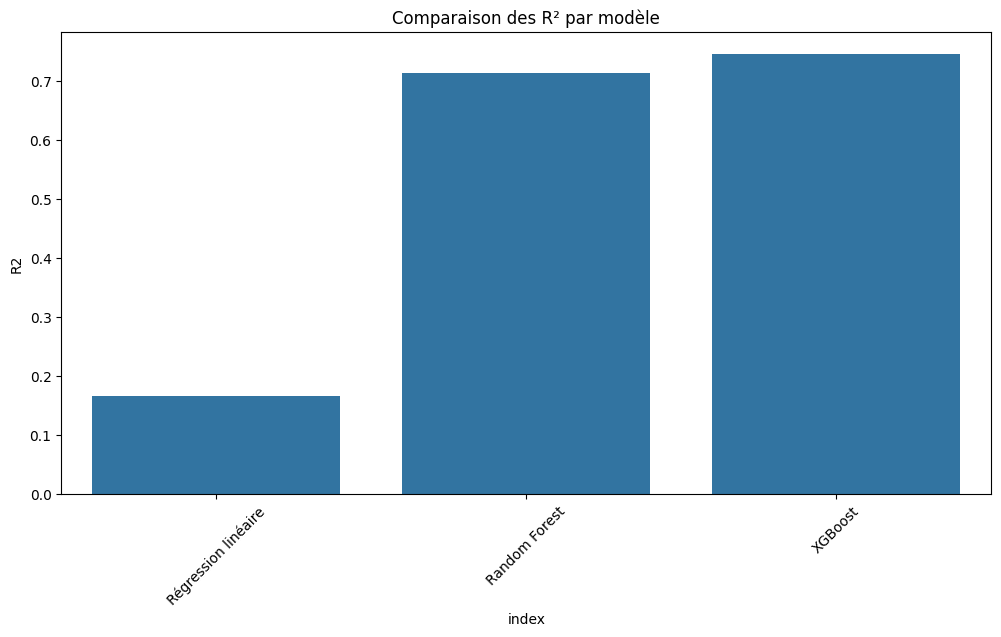

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.reset_index(), x='index', y='R2')
plt.title('Comparaison des R² par modèle')
plt.xticks(rotation=45)
plt.show()

### Prédictions sur une année

Dans cette partie nous avons entrainé un modèle XGBoost par département avec les données des années jusqu'à 2023. 
L'objectif est de prédire les prix des biens de 2024. 

Distribution des années:
year
2014     147182
2015     163032
2016     167885
2017     195087
2018     196301
2019    1373591
2020    4055039
2021    4542635
2022    4340384
2023    3206354
2024    1277125
Name: count, dtype: int64

Nombre de transactions d'entraînement : 18387490
Nombre de transactions de test : 1277125

Traitement du département 75
Nombre de transactions d'entraînement : 3409873
Nombre de transactions de test : 304425

Traitement du département 77
Nombre de transactions d'entraînement : 2605306
Nombre de transactions de test : 165764

Traitement du département 78
Nombre de transactions d'entraînement : 2302965
Nombre de transactions de test : 145430

Traitement du département 91
Nombre de transactions d'entraînement : 2022437
Nombre de transactions de test : 134287

Traitement du département 92
Nombre de transactions d'entraînement : 2443869
Nombre de transactions de test : 166255

Traitement du département 93
Nombre de transactions d'entraînement : 1881028
Nombre de

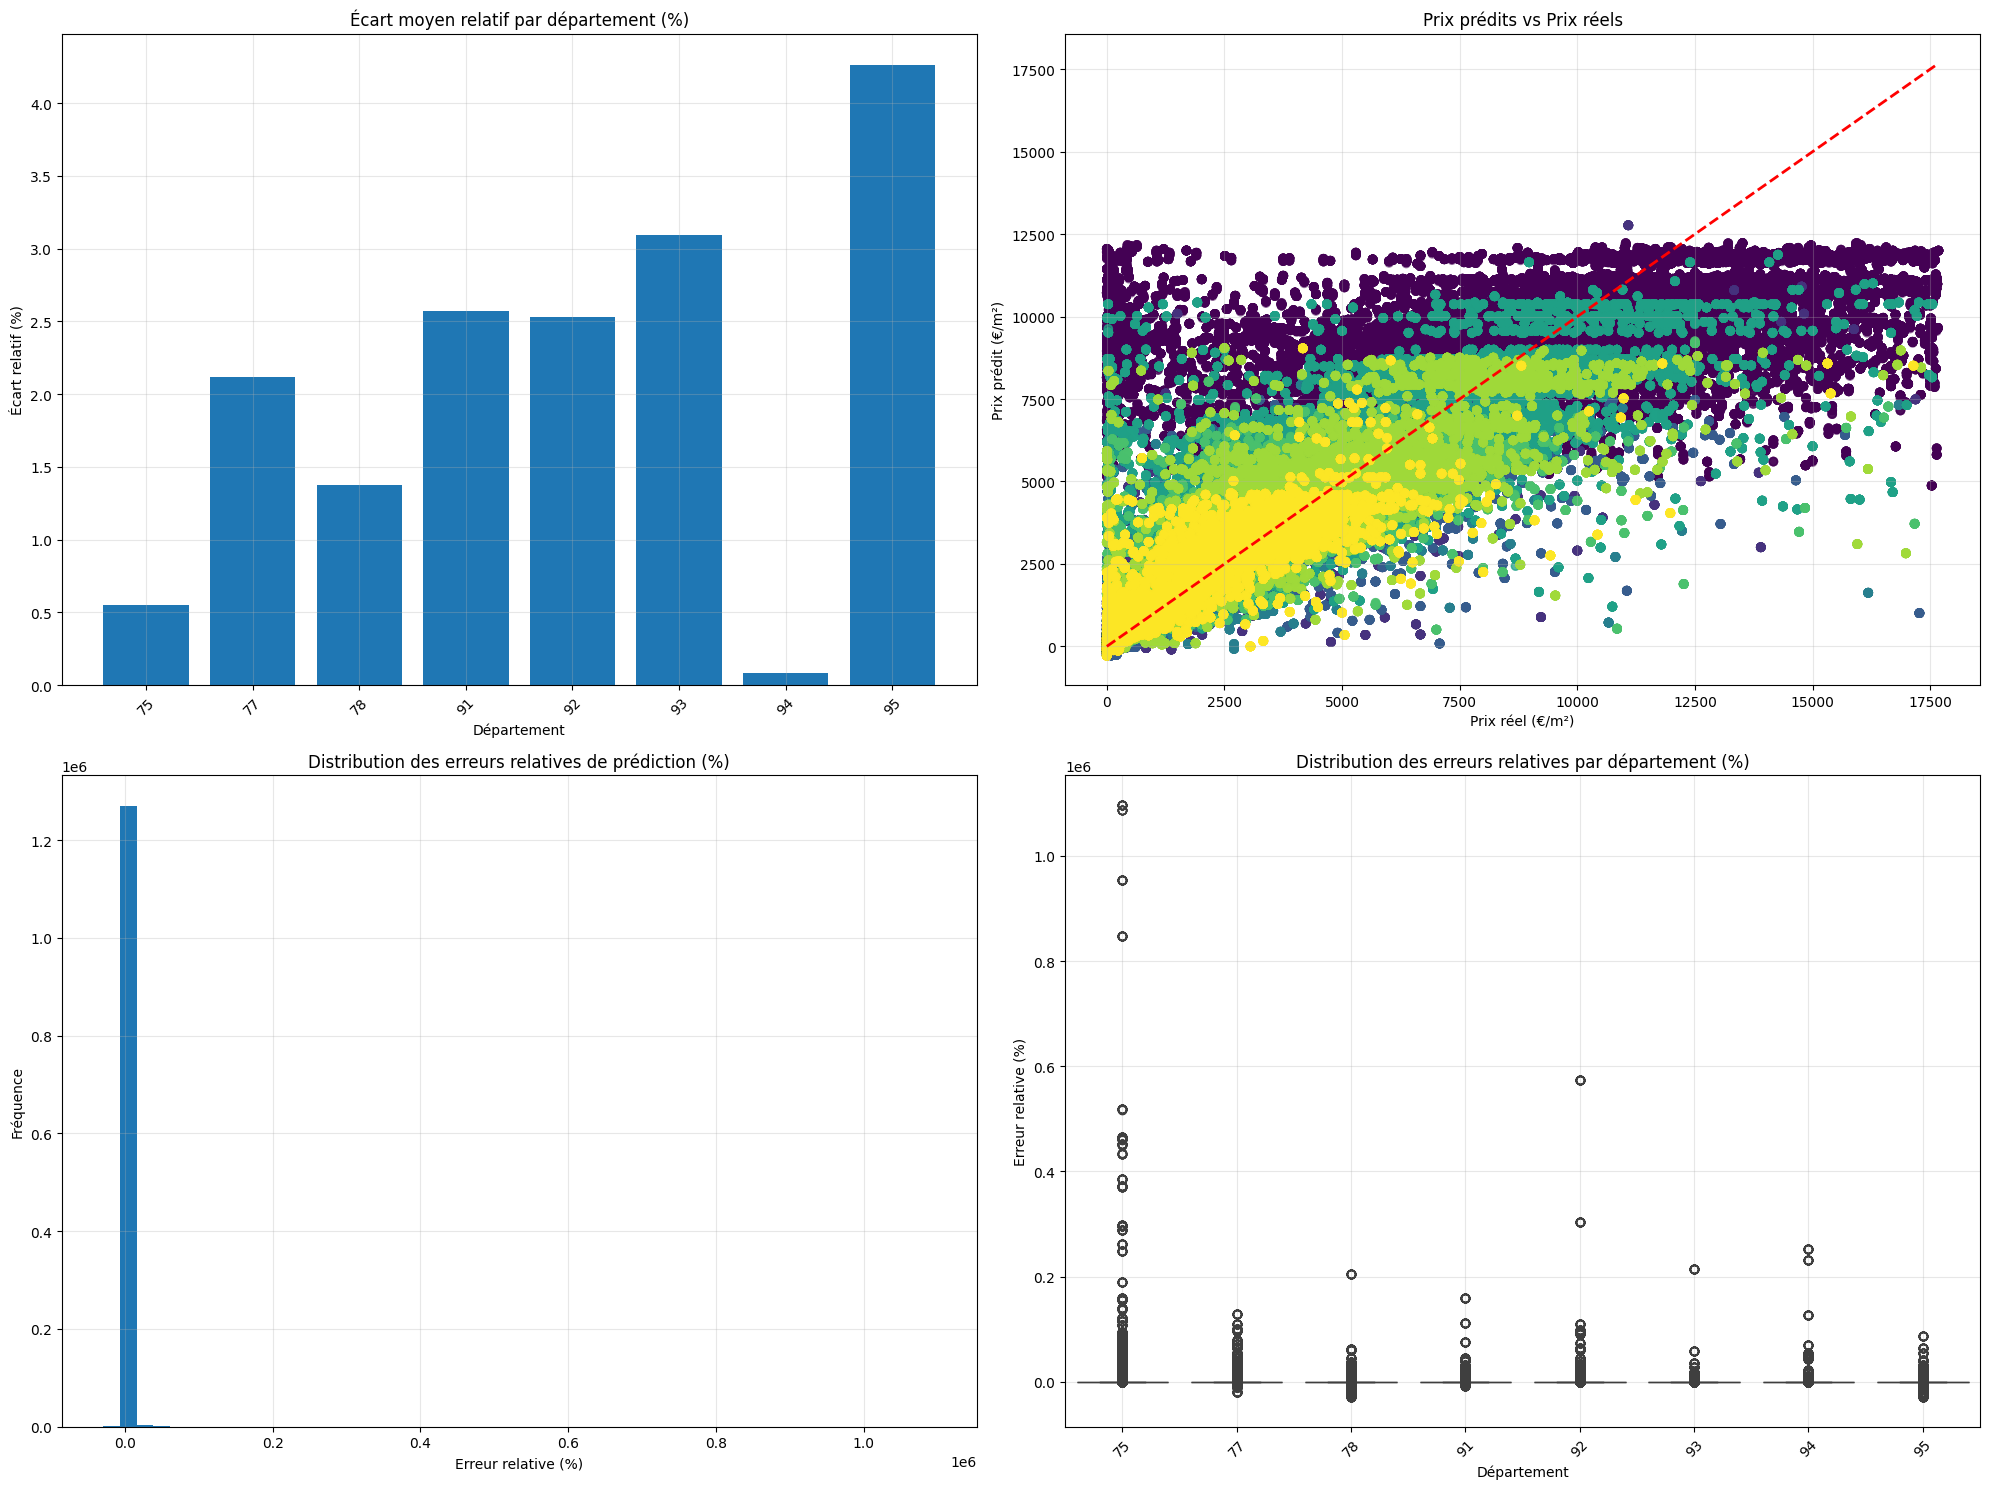


Résultats détaillés des prédictions par département pour 2024:
       RMSE    R2     MAPE  Prix moyen réel  Prix moyen prédit  \
75  2974.22  0.17  1031.35          9168.79            9219.63   
77   733.60  0.80   699.23          1477.57            1508.86   
78  1157.67  0.73   348.22          2666.44            2703.19   
91   768.70  0.74   281.08          1878.06            1926.29   
92  1882.09  0.50   319.57          6064.76            6218.25   
93  1256.55  0.64   140.72          3171.01            3269.16   
94  1376.56  0.68   255.19          4163.48            4167.11   
95   787.03  0.75   329.22          2045.98            2133.20   

    Écart moyen absolu  Écart moyen relatif (%)  Nombre de prédictions  
75               50.84                     0.55               304425.0  
77               31.29                     2.12               165764.0  
78               36.75                     1.38               145430.0  
91               48.23                     2.57  

In [20]:
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Séparation des données d'entraînement (jusqu'à 2023) et de test (2024)
# S'assurer que year_month est bien une chaîne de caractères
df['year_month'] = df['year_month'].astype(str)

# Extraction de l'année
df['year'] = df['year_month'].str.extract('(\d{4})').astype(int)

print("Distribution des années:")
print(df['year'].value_counts().sort_index())

# Remplacement des valeurs NaN dans les variables macroéconomiques par la moyenne
numeric_cols = ['confiance_menages', 'taux_directeur', 'cours_petrole']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

train_df = df[df['year'] < 2024].copy()
test_df = df[df['year'] == 2024].copy()

print(f"\nNombre de transactions d'entraînement : {len(train_df)}")
print(f"Nombre de transactions de test : {len(test_df)}")

# Préparation des features
features = ['surface', 'confiance_menages', 'taux_directeur', 'cours_petrole', 
           'type_bien', 'l_codinsee']

# Dictionnaire pour stocker les résultats par département
results = {}
all_predictions = []  # Pour stocker toutes les prédictions

# Entraînement et prédiction par département
for dept in df['departement'].unique():
    print(f"\nTraitement du département {dept}")
    
    # Filtrer les données pour le département
    dept_train = train_df[train_df['departement'] == dept]
    dept_test = test_df[test_df['departement'] == dept]
    
    if len(dept_test) == 0:
        print(f"Pas de données de test pour le département {dept}")
        continue
    
    if len(dept_train) == 0:
        print(f"Pas de données d'entraînement pour le département {dept}")
        continue
        
    print(f"Nombre de transactions d'entraînement : {len(dept_train)}")
    print(f"Nombre de transactions de test : {len(dept_test)}")
    
    # Préparation des données
    X_train = dept_train[features]
    y_train = dept_train['prix_m2']
    X_test = dept_test[features]
    y_test = dept_test['prix_m2']
    
    # Encodage des variables catégorielles
    for feature in ['type_bien', 'l_codinsee']:
        le = LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature].astype(str))
        X_test[feature] = le.transform(X_test[feature].astype(str))
    
    # Gestion des valeurs manquantes
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=features)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=features)
    
    # Entraînement du modèle XGBoost
    model = xgb.XGBRegressor(
        max_depth=4,
        n_estimators=100,  # Augmenté pour plus de robustesse
        learning_rate=0.1,
        tree_method='hist',
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Stockage des prédictions pour les visualisations
    predictions_df = pd.DataFrame({
        'departement': dept,
        'prix_reel': y_test.values,
        'prix_predit': y_pred,
        'erreur': y_pred - y_test.values,
        'erreur_relative': ((y_pred - y_test.values) / y_test.values) * 100
    })
    all_predictions.append(predictions_df)
    
    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Stockage des résultats
    results[dept] = {
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Prix moyen réel': y_test.mean(),
        'Prix moyen prédit': y_pred.mean(),
        'Écart moyen absolu': abs(y_test.mean() - y_pred.mean()),
        'Écart moyen relatif (%)': ((y_pred.mean() - y_test.mean()) / y_test.mean()) * 100,
        'Nombre de prédictions': len(y_test)
    }

# Compilation de toutes les prédictions
all_predictions_df = pd.concat(all_predictions)

# 1. Visualisation des résultats globaux
plt.figure(figsize=(20, 15))

# Subplot 1: Écart moyen par département
plt.subplot(2, 2, 1)
results_df = pd.DataFrame(results).T
plt.bar(results_df.index, results_df['Écart moyen relatif (%)'])
plt.title('Écart moyen relatif par département (%)')
plt.xlabel('Département')
plt.ylabel('Écart relatif (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Subplot 2: Scatter plot réel vs prédit
plt.subplot(2, 2, 2)
plt.scatter(all_predictions_df['prix_reel'], all_predictions_df['prix_predit'], 
           alpha=0.5, c=all_predictions_df['departement'].astype('category').cat.codes, 
           cmap='viridis')
plt.plot([all_predictions_df['prix_reel'].min(), all_predictions_df['prix_reel'].max()], 
         [all_predictions_df['prix_reel'].min(), all_predictions_df['prix_reel'].max()], 
         'r--', lw=2)
plt.title('Prix prédits vs Prix réels')
plt.xlabel('Prix réel (€/m²)')
plt.ylabel('Prix prédit (€/m²)')
plt.grid(True, alpha=0.3)

# Subplot 3: Distribution des erreurs relatives
plt.subplot(2, 2, 3)
plt.hist(all_predictions_df['erreur_relative'], bins=50)
plt.title('Distribution des erreurs relatives de prédiction (%)')
plt.xlabel('Erreur relative (%)')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

# Subplot 4: Box plot des erreurs relatives par département
plt.subplot(2, 2, 4)
sns.boxplot(x='departement', y='erreur_relative', data=all_predictions_df)
plt.title('Distribution des erreurs relatives par département (%)')
plt.xlabel('Département')
plt.ylabel('Erreur relative (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Affichage des métriques détaillées
print("\nRésultats détaillés des prédictions par département pour 2024:")
results_df = pd.DataFrame(results).T
results_df = results_df.round(2)
print(results_df)

# 3. Analyse des performances par gamme de prix
print("\nAnalyse des performances par gamme de prix:")
all_predictions_df['gamme_prix'] = pd.qcut(all_predictions_df['prix_reel'], 
                                         q=4, 
                                         labels=['Bas', 'Moyen-bas', 'Moyen-haut', 'Haut'])
performance_par_gamme = all_predictions_df.groupby('gamme_prix').agg({
    'erreur_relative': ['mean', 'std'],
    'prix_reel': ['mean', 'count']
}).round(2)
print("\nPerformance par gamme de prix:")
print(performance_par_gamme)

# Sauvegarde des résultats
results_df.to_csv('predictions_2024_par_departement.csv')
all_predictions_df.to_csv('predictions_detaillees_2024.csv')

# Affichage du résumé des prédictions
print("\nRésumé global des prédictions:")
print(f"MAPE moyen : {results_df['MAPE'].mean():.2f}%")
print(f"R² moyen : {results_df['R2'].mean():.3f}")
print(f"Nombre total de prédictions : {results_df['Nombre de prédictions'].sum()}")

### Tests de sur-apprentissage

Analyse du surapprentissage pour Random Forest:


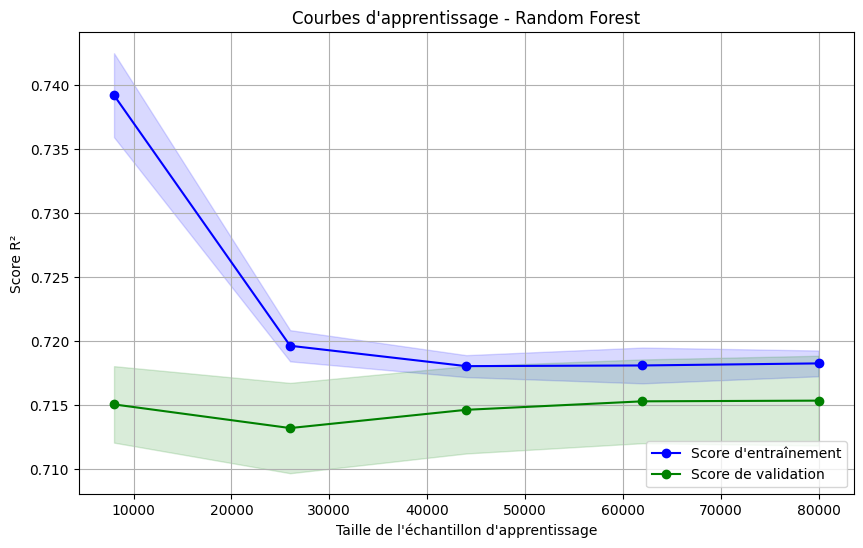


Scores finaux pour Random Forest:
Score d'entraînement moyen: 0.718 (+/- 0.002)
Score de validation moyen: 0.715 (+/- 0.007)
Écart train-validation: 0.003

Analyse du surapprentissage pour XGBoost:


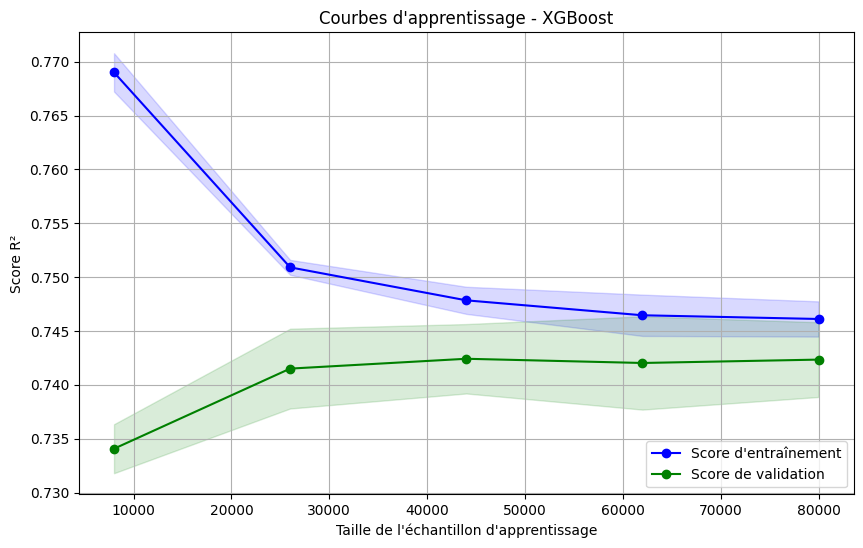


Scores finaux pour XGBoost:
Score d'entraînement moyen: 0.746 (+/- 0.003)
Score de validation moyen: 0.742 (+/- 0.007)
Écart train-validation: 0.004


In [19]:
def plot_learning_curves(model, X, y, model_name, cv=5):
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    # Calculer les courbes d'apprentissage
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='r2',
        n_jobs=-1 
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # Tracer la courbe d'apprentissage (training)
    plt.plot(train_sizes, train_mean, label='Score d\'entraînement', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='blue')
    
    # Tracer la courbe de validation
    plt.plot(train_sizes, val_mean, label='Score de validation', color='green', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='green')
    
    # Personnalisation du graphique
    plt.xlabel('Taille de l\'échantillon d\'apprentissage')
    plt.ylabel('Score R²')
    plt.title(f'Courbes d\'apprentissage - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    print(f"\nScores finaux pour {model_name}:")
    print(f"Score d'entraînement moyen: {train_mean[-1]:.3f} (+/- {train_std[-1]*2:.3f})")
    print(f"Score de validation moyen: {val_mean[-1]:.3f} (+/- {val_std[-1]*2:.3f})")
    print(f"Écart train-validation: {train_mean[-1] - val_mean[-1]:.3f}")

sample_size = 100000  
random_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sample = X_train.iloc[random_indices]
y_sample = y_train.iloc[random_indices]

print("Analyse du surapprentissage pour Random Forest:")
plot_learning_curves(
    models['Random Forest'],
    X_sample,
    y_sample,
    'Random Forest'
)

print("\nAnalyse du surapprentissage pour XGBoost:")
plot_learning_curves(
    models['XGBoost'],
    X_sample,
    y_sample,
    'XGBoost'
)

#### Analyse des résidus
Le modèle semble avoir des difficultés à prédire correctement les prix élevés (au-delà de 10000). Il tend à sous-estimer systématiquement ces valeurs. Pour les prix plus bas (inférieurs à 10000), les prédictions semblent plus précises, avec une distribution plus proche de la ligne idéale.
Il y a une forte densité de points dans la partie inférieure du graphique, suggérant que la majorité des données concerne des prix plus bas.

#### Pistes d'amélioration

- Un rééchantillonnage des données pour mieux représenter les prix élevés
-  Une transformation logarithmique des prix pour mieux gérer les grandes valeurs
- L'ajout de features plus pertinentes pour la prédiction des prix élevés
- L'utilisation d'un ensemble de modèles spécialisés par gamme de prix

## Conclusion

L'analyse du marché immobilier francilien révèle une dynamique où la géographie prime sur l'économie. Notre modélisation XGBoost, avec un R² de 0.74, démontre que le département est le facteur déterminant des prix, loin devant les variables macroéconomiques (corrélations < 0.03). 
Cette faible influence des indicateurs économiques traditionnels (taux directeur, confiance des ménages, cours du pétrole) suggère un marché résilient aux cycles économiques.

La comparaison entre Paris (médiane ~10,000€/m²) et sa périphérie (2,500-5,000€/m²) illustre une forte segmentation géographique. L'évolution 2014-2024 montre une hausse continue des prix (+29%), accélérée post-2020, témoignant d'un marché dynamique malgré les crises.

Bien que performant, le modèle pourrait être amélioré par l'intégration de données locales (transports, services) et une segmentation plus fine. 